In [2]:
import sys
import subprocess
import requests
import time
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from bayes_opt import SequentialDomainReductionTransformer
bounds_transformer = SequentialDomainReductionTransformer()
import matplotlib as mtp
mtp.rcParams.update({'font.size':16})
import numpy as np
from random import *
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
seed(5000)
factor = 5000 #Why?

In [3]:
def get_exectime(x, y): # make a call to FaaS platform to get runtime
    # Configuring serverless function with suggested parameters
    deploy_command = f"gcloud functions deploy io-intensive \
        --source=https://source.developers.google.com/projects/woven-ceremony-418503/repos/io-intensive \
        --trigger-http \
        --runtime=python312 \
        --allow-unauthenticated \
        --entry-point=io_http \
        --region=us-central1 \
        --gen2 \
        --memory={x}Mi \
        --cpu={y}"

    # Execute the command
    output = subprocess.run(deploy_command, shell=True, check=True, capture_output=True)
    if output.stdout:
        print(f"Update complete: Memory (MiB): {x}, vCPUs: {y}")
    
    # Make a HTTP request and get the execution time
    start_time = time.time()
    requests.get("https://source.developers.google.com/projects/woven-ceremony-418503/repos/io-intensive")
    end_time = time.time()
    exec_time = end_time - start_time
    return exec_time

# 등급 1 가격 기준 (단위 $)
def get_gcf_cost (exec_time, x, y):
    ''' 호출비용 + 단위메모리당 비용(x) + 단위cpu당 비용(y)'''
    return 0.0000004 + (0.0000025 * (x / 1024.0) * exec_time) + (0.0000100 * (y * 2.4) * exec_time)

def next_finder (x, y):
    CONFIGURATIONS = [
    (128, 0.083), (128, 0.167), (128, 0.333), (128, 0.583), (128, 1), (128, 2),
    (256, 0.083), (256, 0.167), (256, 0.333), (256, 0.583), (256, 1), (256, 2),
    (512, 0.083), (512, 0.167), (512, 0.333), (512, 0.583), (512, 1), (512, 2),
    (1024, 0.583), (1024, 1), (1024, 2), 
    (2048, 1), (2048, 2), (2048, 4),
    (4096, 1), (4096, 2), (4096, 4), (4096, 6), (4096, 8), 
    (8192, 2), (8192, 4), (8192, 6), (8192, 8), 
    (16384, 4), (16384, 6), (16384, 8)
    ]

    # Find min and max values for normalization
    max_memory = max(config[0] for config in CONFIGURATIONS)
    min_memory = min(config[0] for config in CONFIGURATIONS)
    max_vCPUs = max(config[1] for config in CONFIGURATIONS)
    min_vCPUs = min(config[1] for config in CONFIGURATIONS)  

    # Normalize
    norm_memory = (x - min_memory) / (max_memory - min_memory)
    norm_vCPUs = (y - min_vCPUs) / (max_vCPUs - min_vCPUs)

    # Distance calculation with normalized values
    distances = [
        np.linalg.norm(
            np.array([
                (config[0] - min_memory) / (max_memory - min_memory), 
                (config[1] - min_vCPUs) / (max_vCPUs - min_vCPUs)
            ]) - np.array([norm_memory, norm_vCPUs])
        )
        for config in CONFIGURATIONS  
    ]

    closest_index = np.argmin(distances)
    
    memory, vCPUs = CONFIGURATIONS[closest_index]
    return {'x': memory, 'y': vCPUs}

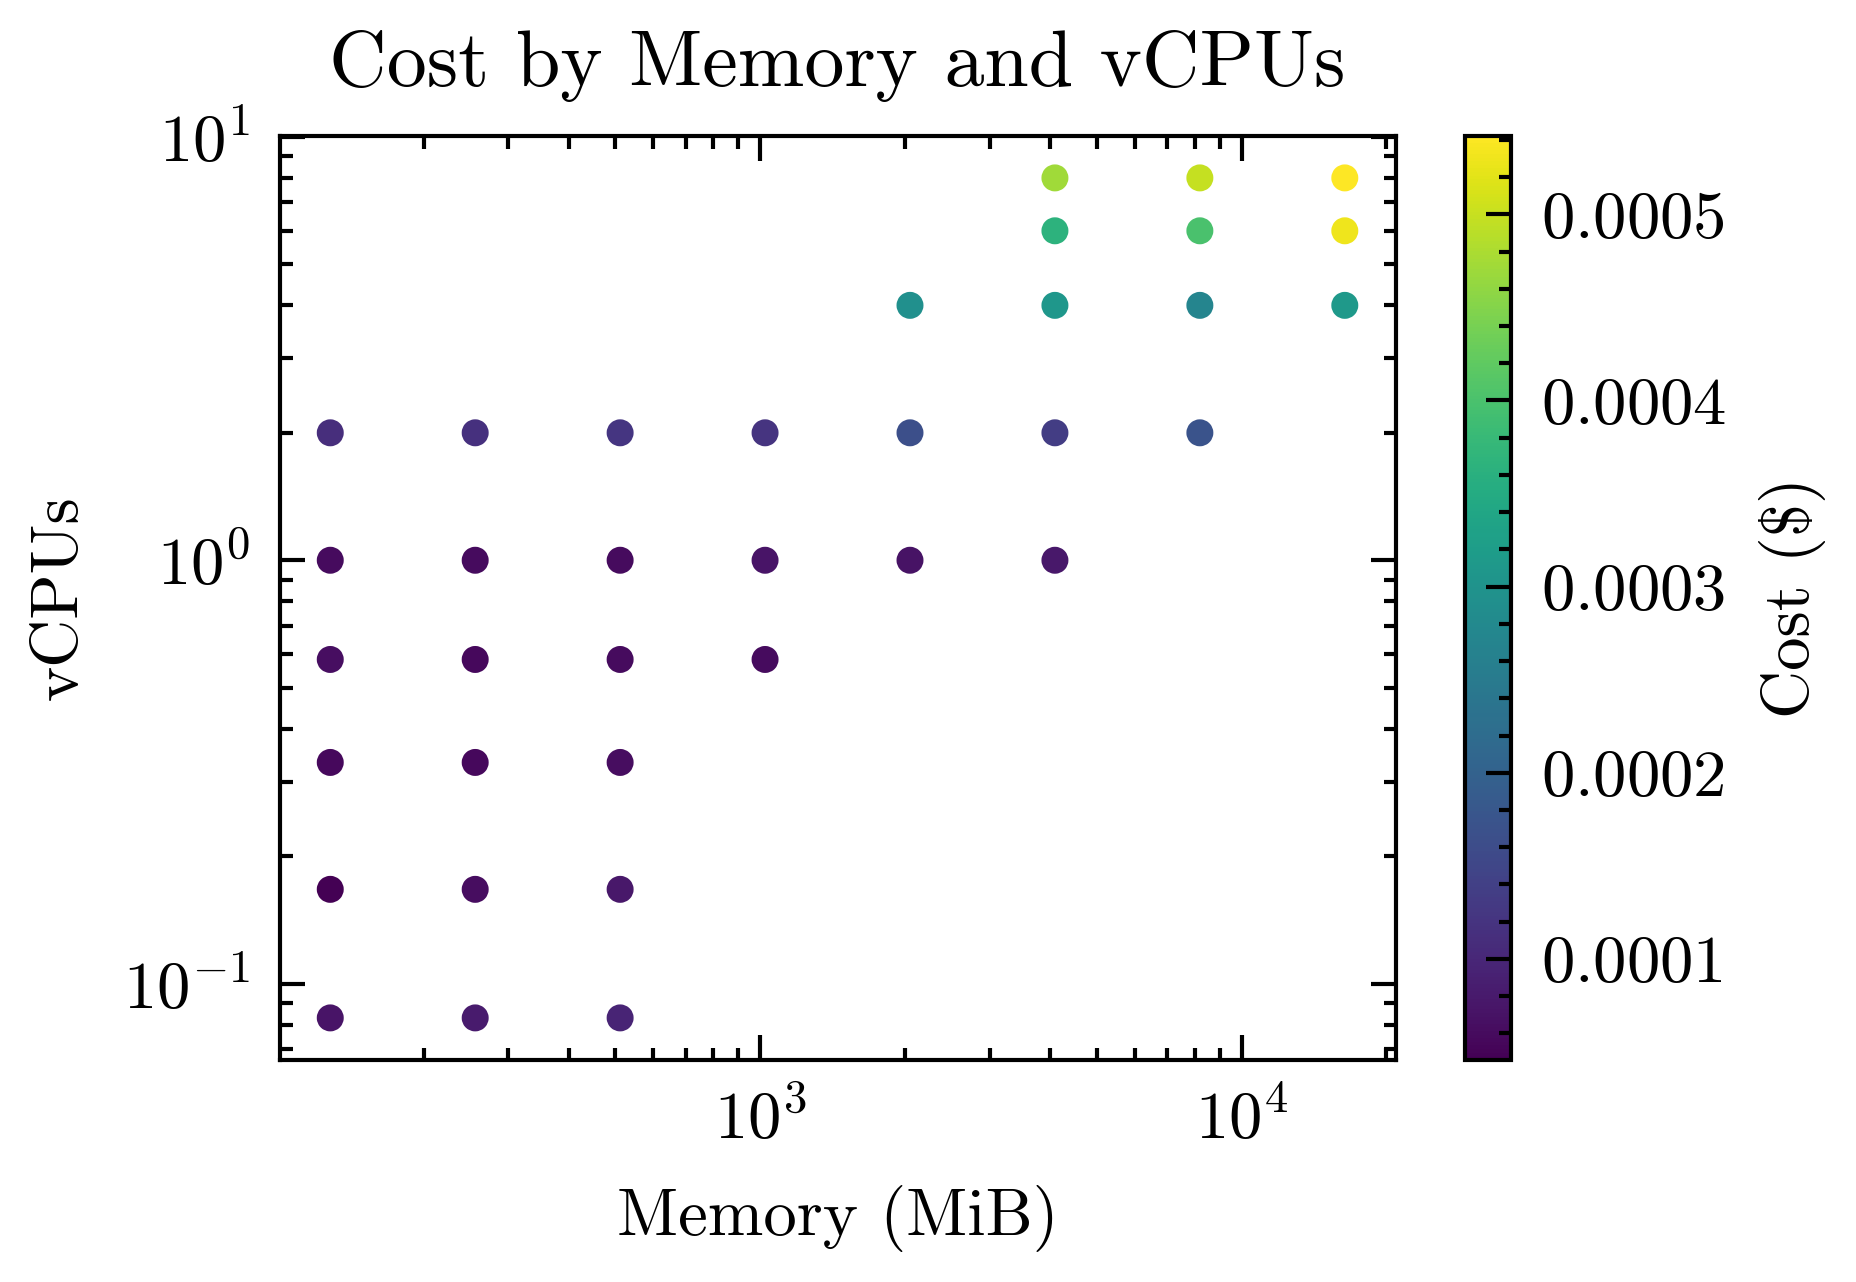

In [13]:
# x = np.linspace(128, 16384, 16384-128).reshape(-1, 1) # memory
# y = np.linspace(0.083, 8, 800 - 8).reshape(-1, 1) # vcpus
# # node_type = np.linspace(0, 10000, 2).reshape(-1, 1)
# z_c = get_exectime(x, y)*factor
# plt.plot(x, y, z_c, label='Ground Truth')
# plt.legend(loc='upper right')
# plt.show()

import pandas as pd
import scienceplots

# Load your data from the CSV file
df = pd.read_csv('benchmark_results_cost.csv')

# Extract the columns of interest
memory = df['Memory (MiB)']
vcpus = df['vCPUs']
# execution_time = df['Avg. Execution Time']
cost = df['Cost ($)']

# 2D Scatter Plot (Memory vs. Execution Time)
plt.style.use(['science', 'ieee', 'no-latex'])
plt.figure(figsize=(3, 2))  # Adjust figure size as needed 
# plt.grid(True, 'major', 'both')
# plt.scatter(memory, vcpus, c=execution_time, cmap='viridis', s=5, linewidths=1)  # Color by executiontime
plt.scatter(memory, vcpus, c=cost, cmap='viridis', s=5, linewidths=1)  # Color by cost
plt.xlabel('Memory (MiB)')
plt.ylabel('vCPUs')
plt.xscale('log')
plt.yscale('log')

plt.title('Cost by Memory and vCPUs')
plt.colorbar(label='Cost ($)')
plt.show()

In [10]:
# define exploration space i.e. memory values 
pbounds = { 'x': (128, 16384), 'y': (0.083, 8)}

optimizer = BayesianOptimization(
    f=None,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=randint(128, 16384) # seed를 128, 3008로 잡은 이유가 있는지?
)

# BO parameters 

acq_type = "ei"
xi_value = 0.001 # more exploration 
kappa_value = 10.0
alpha_value = 0.1
utility = UtilityFunction(kind=acq_type, kappa = kappa_value, xi=xi_value)


In [ ]:
def posterior(optimizer, x_obs, y_obs, z_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma


def plot_gp(optimizer, x, y, z_c, acq_type, xi_value, kappa_value):
    global graph_counter
    fig = plt.figure(figsize=(7, 7, 7))
    steps = len(optimizer.space)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])    
    plt.subplots_adjust(wspace=0, hspace=0.12)
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([[res["params"]["y"]] for res in optimizer.res])
    z_obs = np.array([res["target"] for res in optimizer.res])
    mu, sigma = posterior(optimizer, x_obs, y_obs, z_obs, x)
    # axis.plot(x, get_runtime(x)*factor, linewidth=3, label='Measured')
    # axis.plot(x, mu*factor, '--', color='k', label='Prediction')
    # axis.plot(x_obs.flatten(), get_runtime(x_obs)*factor, 'D', markersize=8, label=u'Observations', color='r')
    # axis.fill_between(x.flatten(), (mu + sigma)*factor, (mu - sigma)*factor, alpha=0.3)

    axis.set_xlim((128, 16384))
    axis.set_ylim((0.083, 8))
    axis.set_zlim((0, 40))
    axis.set_xlabel('Memory (MB)', fontdict={'size':20})
    axis.set_ylabel('vCPU', fontdict={'size':20})
    axis.set_zlabel('Execution Time (ms)', fontdict={'size':20})
    z_max = optimizer.max['target']
    axis.legend(loc=1, bbox_to_anchor=(0.77, 0.99), borderaxespad=0., ncol=2, prop={'size': 14})
    return mu,sigma

In [22]:
# BO in action ...
counter = 1
total_samples = 96

# (128, 0.083), (512, 0.333), (4096, 2), (16384, 8)
init_list = [ {'x': 128, 'y': 0.083}, {'x': 512, 'y': 0.333}, {'x': 4096, 'y': 2}, {'x': 16384, 'y': 8} ]
print("Initial points probing...\n")
for i in range(4):
    next_point = init_list[i]
    print("Next point to probe is:", next_point)
    target = get_exectime(**next_point)
    target = 1 / get_gcf_cost(target, **next_point)
    print("Found the target value to be:", 1 / target)
    next_point['x'] = next_point['x'] + random()
    # next_point['y'] = next_point['y'] + random()
    print("After randomized:", next_point, "\n")
    optimizer.register(params=next_point, target=target)

print("Main phase initiated...\n")

while True:
    next_point = optimizer.suggest(utility)
    print(f"Before: ", next_point)
    next_point = next_finder(**next_point)
    print(f"After: ", next_point)
    print("Next point to probe is:", next_point)
    target = get_exectime(**next_point) # target means 'execution time'
    target = 1 / get_gcf_cost(target, **next_point) # target changes to 'cost(inverted)'
    print("Found the target value to be:", 1 / target)
    next_point['x'] = next_point['x'] + random()
    # next_point['y'] = next_point['y'] + random() # randomizing y -> fluctuating result
    print("After randomized: ", next_point)
    optimizer.register(params=next_point, target=target)
    # optimizer.set_gp_params(alpha=alpha_value)
    # optimizer.set_gp_params(normalize_y=True)

    # mu, sigma = plot_gp(optimizer, x, y, z_c, acq_type, xi_value, kappa_value)
    print ('Samples so far:', counter, "\n")
    counter+=1
    if counter > total_samples:
        break
    
print("BEST:", 1 / optimizer.max['target'], optimizer.max['params'])


Initial points probing...

Next point to probe is: {'x': 128, 'y': 0.083}
Update complete: Memory (MiB): 128, vCPUs: 0.083
Found the target value to be: 1.6639442168474198e-06
After randomized: {'x': 128.17903746574098, 'y': 0.083} 

Next point to probe is: {'x': 512, 'y': 0.333}
Update complete: Memory (MiB): 512, vCPUs: 0.333
Found the target value to be: 3.4735950145721436e-06
After randomized: {'x': 512.1830513624645, 'y': 0.333} 

Next point to probe is: {'x': 4096, 'y': 2}
Update complete: Memory (MiB): 4096, vCPUs: 2
Found the target value to be: 2.020306148529053e-05
After randomized: {'x': 4096.177276134336, 'y': 2} 

Next point to probe is: {'x': 16384, 'y': 8}
Update complete: Memory (MiB): 16384, vCPUs: 8
Found the target value to be: 0.00010342796936035155
After randomized: {'x': 16384.973713437998, 'y': 8} 

Main phase initiated...

Before:  {'x': 1692.8786457862436, 'y': 1.4992405409669132}
After:  {'x': 2048, 'y': 1}
Next point to probe is: {'x': 2048, 'y': 1}
Update co

In [ ]:
##plot grounth truth and prediction

In [ ]:
predicted_runtimes = mu*factor

# plt.plot(x, get_runtime(x)*factor, linewidth=3, label='ground truth')
# plt.plot(x,predicted_runtimes, '--', color='k', label='Prediction')
plt.xlabel('memory (MB)')
plt.ylabel('vCPU')
plt.zlabel('runtime (s)')
plt.legend()
